In [7]:
# IMPORT LIBRARIES

import numpy as np
import math
import statistics
import re
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

from fastai import *
from fastai.tabular import *

Using TensorFlow backend.


In [13]:
# READ IN CSV

higgs_train = pd.read_csv('training.csv')
train = higgs_train.drop(['EventId','Weight'], axis=1)


higgs_test = pd.read_csv('test.csv')
test = higgs_test.drop(['EventId'], axis=1)


weights = higgs_train.iloc[:,-2]
cont_features = higgs_train.drop(['EventId','Weight','PRI_jet_num'], axis=1)

In [16]:
# FIX -999 VALUES, CONVERT TO MEDIANS

for i in np.arange(len(train.columns)-1):
    train.iloc[:,i] = train.iloc[:,i].replace(-999,np.median(train.iloc[:,i]))

for i in np.arange(len(test.columns)):
    train.iloc[:,i] = train.iloc[:,i].replace(-999,np.median(train.iloc[:,i]))

In [17]:
# LABEL COLUMNS

dep_var = train.columns[-1]
cat_names = ['PRI_jet_num']
cont_names = list(cont_features.columns)[0:-1]
procs = [FillMissing, Categorify]

In [18]:
# CHECK FOR NULL VALUES

np.count_nonzero(train.isnull().values == True)

0

In [37]:
# CREATE TABULAR DATABUNCH

data = (TabularList.from_df(df = train, cat_names=cat_names, cont_names=cont_names, procs=procs)
.split_by_idx(train.tail(50000).index)
.label_from_df(cols=dep_var)
.databunch())

In [32]:
data = TabularDataBunch.from_df('higgs_data', df=train, dep_var=dep_var, valid_idx=train.tail(50000).index, procs=procs, cat_names=cat_names, cont_names=cont_names, test_df=test)

In [33]:
# CREATE TABULAR LEARNER

learner = tabular_learner(data, layers = [1000, 500] , metrics = accuracy)

In [34]:
# TRAIN LEARNER

learner.fit_one_cycle(3, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.391741,0.380253,0.830020,00:28
1,0.373770,0.370827,0.836780,00:28
2,0.368982,0.362818,0.840160,00:28


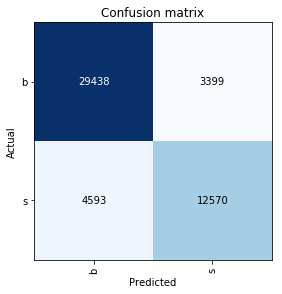

In [35]:
# PLOT CONFUSION MATRIX (for validation set)

interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

In [36]:
# EVALUATION METRIC FOR CHALLENGE

def AMS(s, b):
    """ Approximate Median Significance defined as:
        AMS = sqrt(
                2 { (s + b + b_r) log[1 + (s/(b+b_r))] - s}
              )        
    where b_r = 10, b = background, s = signal, log is natural logarithm """
    
    br = 10.0
    radicand = 2 *( (s+b+br) * math.log (1.0 + s/(b+br)) -s)
    if radicand < 0:
        print('radicand is negative. Exiting')
        exit()
    else:
        return math.sqrt(radicand)

In [110]:
# LOAD PREDICTIONS

predictions = learner.get_preds(ds_type=DatasetType.Test, with_loss=False)

In [120]:
# GET PREDICTED CLASSES

predicted_classes = []
for i in range(len(data.test_ds)):
    if predictions[0][i][1] > predictions[0][i][0]:
        predicted_classes.append('s')
    else:
        predicted_classes.append('b')

In [158]:
# GET PREDICTION PROBABILITIES

prediction_probs = []
for i in range(len(data.test_ds)):
    prediction_probs.append((float(predictions[0][i][1].numpy())))

In [179]:
# CREATE PRELIMINARY SUBMISSION FILE

submission = pd.DataFrame({'EventId': higgs_test['EventId'],
                          'RankOrder': prediction_probs,
                          'Class': predicted_classes})
submission = submission.sort_values(by=['RankOrder'])
submission.head(1)

,EventId,RankOrder,Class
262327,612327,7.583629e-07,b
193238,543238,5.496273e-06,b
237720,587720,6.316556e-06,b
97172,447172,2.829122e-05,b
144075,494075,3.037607e-05,b


In [180]:
# CONVERT PROBS TO RANK ORDER

for i in range(len(submission)):
    submission.iloc[i,1] = int(i + 1)

In [206]:
# CONVERT RANK ORDERS TO INT32

ranks = []
for i in range(550000):
    ranks.append(int(submission.iloc[i,1]))

submission['RankOrder'] = ranks

In [182]:
# SORT BY EVENT ID

submission = submission.sort_values(by=['EventId'])

In [207]:
# CREATE FINAL SUBMISSION FILE

submission = pd.DataFrame({'EventId': higgs_test['EventId'],
                          'RankOrder': ranks,
                          'Class': predicted_classes})
submission.head(1)

,EventId,RankOrder,Class
0,350000,550000,s


In [205]:
# EXPORT TO CSV

submission.to_csv('submission.csv', sep=',', index=False, index_label=False)